In [3]:
!pip install faker
!pip install babel

In [4]:
import torch
import torch.nn as nn
import string
import numpy as np
import random
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from IPython.core.debugger import set_trace
import IPython
import matplotlib.pyplot as plt
from PIL import Image

from faker import Faker
import random
from babel.dates import format_date
import re
import itertools
from datetime import date
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset

In [5]:
fake = Faker()

# We need to seed these guys. For some reason I always use 101
Faker.seed(101)
random.seed(101)

In [6]:
FORMATS = ['short', # d/M/YY
           'medium',
           'long',
           'full',
           'd MMM YYY', 
           'd MMMM YYY',
           'dd/MM/YYY',
           'EE d, MMM YYY',
           'EEEE d, MMMM YYY']

In [7]:
def random_date():
    start_date = date(2000, 1, 1); end_date = date(2024, 1, 1)
    #dt = fake.date_object()
    dt = fake.date_between(start_date=start_date, end_date=end_date)

    try:
        date_ = format_date(dt, format=random.choice(FORMATS), locale='en')
        human_readable = date_.lower().replace(',', '')
        machine_readable = dt.isoformat()

    except AttributeError as e:
        return None, None, None

    return human_readable, machine_readable, dt

In [8]:
def create_dataset(num_examples:int):
    x = list(); y = list();
    
    for _ in range(num_examples):
        hr, mr, _ = random_date()
        hr = re.split(r'\s|/', hr); mr = re.split(r'-', mr)
        
        x.append(hr); y.append(mr)
    
    return x, y

In [9]:
human_readables, machine_readables = create_dataset(10000)
hr_val, mr_val = create_dataset(1000)

In [11]:
max_len_hr = max(list(map(len, human_readables)))
max_len_hr

4

In [23]:
hr_flattened = list(itertools.chain.from_iterable(human_readables))
print(len(hr_flattened))
hr_vocab = list(set(hr_flattened))
print(len(hr_vocab))

mr_flattened = list(itertools.chain.from_iterable(machine_readables))
print(len(mr_flattened))
mr_vocab = list(set(mr_flattened))
print(len(mr_vocab))

hr_to_id = {_:i+1 for i, _ in enumerate(hr_vocab)}
id_to_hr = {i+1:_ for i, _ in enumerate(hr_vocab)}
hr_to_id['<unk>'] = 0
id_to_hr[0] = '<unk>'

mr_to_id = {_:i+1 for i, _ in enumerate(mr_vocab)}
id_to_mr = {i+1:_ for i, _ in enumerate(mr_vocab)}
mr_to_id['<unk>'] = 0
id_to_mr[0] = '<unk>'

33294
103
30000
55


In [15]:
def get_sequences(hr, mr):
    human_readable_sequences = [list(map(lambda x: hr_to_id[x], x)) for x in hr]
    machine_readable_sequences = [list(map(lambda x: mr_to_id[x], x)) for x in mr]
    print(human_readable_sequences[:5], machine_readable_sequences[:5], sep='\n')
    
    return human_readable_sequences, machine_readable_sequences

human_readable_sequences, machine_readable_sequences = get_sequences(human_readables, machine_readables)
hr_val_sequences, mr_val_sequences = get_sequences(hr_val, mr_val)

[[39, 68, 9, 102], [18, 24, 66, 53], [83, 61, 84], [49, 35, 15, 43], [24, 10, 36]]
[[45, 17, 17], [46, 13, 51], [11, 51, 9], [33, 51, 6], [37, 51, 18]]
[[58, 77, 98], [68, 67, 56], [23, 81, 7, 5], [81, 10, 103], [76, 59, 14, 43]]
[[32, 31, 47], [54, 17, 36], [4, 25, 15], [52, 25, 18], [33, 9, 30]]


In [16]:
pad_sequences = lambda sequences: pad_sequence(list(map(torch.tensor, sequences)), batch_first=True)

hr_sequences_padded = pad_sequences(human_readable_sequences)
hr_val_sequences_padded = pad_sequences(hr_val_sequences)

machine_readable_sequences = torch.tensor(machine_readable_sequences)
mr_val_sequences = torch.tensor(mr_val_sequences)

In [17]:
class CustomData(Dataset):
    def __init__(self, x_data, y_data):
        super().__init__()
        self.x_data = x_data
        self.y_data = y_data
        
    def __len__(self):
        return len(self.x_data)
    
    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx]
    
dataset = CustomData(hr_sequences_padded, machine_readable_sequences)
val_dataset = CustomData(hr_val_sequences_padded, mr_val_sequences)

train_loader = DataLoader(dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=True)

In [19]:
decode_text = lambda x_: [id_to_mr[_] for _ in x_]
decode_text(mr_val_sequences[0].tolist())

['2005', '07', '08']

In [20]:
class AttentionModel(nn.Module):
    def __init__(self, encoder_vocab_size, decoder_vocab_size,
                 encoder_dim, decoder_dim, input_features_dim, output_features_dim, 
                 timesteps_encoder, timesteps_decoder, num_training):
        super().__init__()
        self.timesteps_encoder = timesteps_encoder
        self.timesteps_decoder = timesteps_decoder
        self.input_features_dim = input_features_dim
        self.encoder_vocab_size = encoder_vocab_size
        self.decoder_vocab_size = decoder_vocab_size
        
        self.densor1 = nn.Linear(decoder_dim+(2*encoder_dim), 10)
        self.tanh = nn.Tanh()
        self.densor2 = nn.Linear(10, 1)
        self.softmax = nn.Softmax(dim=1)
        
        self.encoder_emb = nn.Embedding(encoder_vocab_size, 32)
        self.pre_attention_lstm = nn.LSTM(input_size=32, hidden_size=encoder_dim, batch_first=True, bidirectional=True)
        
        #self.decoder_emb = nn.Embedding(decoder_vocab_size, 32)
        self.post_attention_lstm = nn.LSTM(input_size=encoder_dim*2, hidden_size=decoder_dim, batch_first=True)
        self.output_layer = nn.Linear(decoder_dim, decoder_vocab_size)
        
        
    def forward(self, x, s0, c0):
        # x-> (B, timesteps, features) -> (128, 10, 26)
        # s0, c0 -> (1, B, decoder_dim) -> (1, 128, 16)
        #set_trace()
        self.s = s0; self.c = c0
        x = self.encoder_emb(x)
        encoder_hidden_states, (hn, cn) = self.pre_attention_lstm(x) #hidden_states: (B, timesteps, encoder_dim*2) -> (128, 10, 16)
        outputs = list()
        
        for t in range(self.timesteps_decoder):
            context = self.one_step_attention(encoder_hidden_states) # (B, timesteps, 2*encoder_dim)
            _, (self.s, self.c )= self.post_attention_lstm(context, (self.s, self.c)) # _ -> (B, timesteps, decoder_dim)
            output = self.output_layer(self.s) # (1, B, output_features_dim) -> (1, 128, 26)
            outputs.append(output) # (timesteps, B, output_features_dim) -> (10, 128, 26)
        
        return outputs
    
    def one_step_attention(self, encoder_hidden_states):
        # encoder_Hidden_states -> (B, timesteps, 2*encoder_dim) -> (128, 10, 16)
        # self.s -> (1, B, decoder_dim)
        # 1. first the hidden state for decoder must be repeated to match the hidden states of encoder
        # self.s -> (timesteps, B, decoder_dim) -> permute -> (B, timesteps, decoder_dim)
        # 2. then concatenate the hidden state for decoder and the hidden state for encoder -> (B, timesteps, 2*encoder_dim + decoder_dim)
        # pass it through the first dense layer
        # pass it through the second dense layer
        # use softmax to decide which hidden state of encoder is the most important
        # use dot product to find the important hidden state of encoder and feed it as input to the decoder
        hidden_decoder = self.s.repeat(self.timesteps_encoder, 1, 1).permute(1, 0, 2) # (B, timesteps, decoder_dim) -> (128, 10, 16)
        concat = torch.concatenate([encoder_hidden_states, hidden_decoder], dim=-1) # (B, timesteps, 2*encoder_dim + decoder_dim) -> (128, 10, 32)
        e = self.tanh(self.densor1(concat)) # (B, timesteps, 10) -> (128, 10, 10)
        energies = self.softmax(self.densor2(e)) # (B, timesteps, 1) -> (128, 10, 1)
        # let's if without permute in next step if the code converges
        energies = energies.repeat(1, 1, self.timesteps_encoder).permute(0, 2, 1) # (B, timesteps, 10) -> (B, 10, 10)
        context = torch.bmm(energies, encoder_hidden_states) # (B, timesteps, timesteps) @ (B, timesteps, 2*encoder_dim) -> (B, timesteps, 2*encoder_dim)
        
        return context
        
    def predict(self, test_input):
        #assert len(test_input.split()) == self.timesteps_encoder
        #out = torch.tensor([hr_to_id[x] for x in test_input.split()])
        #out = pad_sequence(, batch_first=True)
        s0 = torch.zeros(1, 1, decoder_dim); c0 = torch.zeros(1, 1, decoder_dim)
        
        pred = self.forward(test_input, s0, c0)
        #set_trace()
        pred = '-'.join(decode_text([torch.argmax(t, dim=-1).tolist()[0][0] for t in pred]))
        return pred

In [21]:
def calculate_loss(y_true, y_pred):
    ce = nn.CrossEntropyLoss()
    total = 0
    for target, logit in zip(list(y_true), list(y_pred)):
        loss = ce(logit[0], target)
        total += loss
        
    return total

In [33]:
imp = list()

def hook_function(module, input, output):
    if not am.training and heatmap:
        #set_trace()
        imp.append(output[0].flatten().tolist())

In [34]:
encoder_dim = 8
decoder_dim = 16
input_features_dim = features = None
output_features_dim = features = None
encoder_vocab_size, decoder_vocab_size = len(hr_to_id), len(mr_to_id)
timesteps_encoder = max_len_hr
timesteps_decoder = 3 # hard coding
num_training = 10000
epochs = 40
heatmap = False

attention_dict = dict()

s0, c0 = torch.zeros(1, num_training, decoder_dim), torch.zeros(1, num_training, decoder_dim)

am = AttentionModel(encoder_vocab_size, decoder_vocab_size, encoder_dim, decoder_dim,
                    input_features_dim, output_features_dim, 
                    timesteps_encoder, timesteps_decoder, num_training)
opt = optim.Adam(am.parameters())

In [35]:
for name, layer in am.named_children():
    if name == 'softmax':
        print(layer)
        handle = layer.register_forward_hook(hook_function)

Softmax(dim=1)


In [36]:
for epoch in range(epochs):
    am.train()
    train_loss = list()
    for i, (inputs, target) in enumerate(train_loader):
        #set_trace()
        target = target.permute(1, 0)
        batch_size = inputs.size(0)
        s0 = torch.zeros(1, batch_size, decoder_dim); c0 = torch.zeros(1, batch_size, decoder_dim)
        outputs = am(inputs, s0, c0)
        
        opt.zero_grad()
        #set_trace()
        total_loss = calculate_loss(target, outputs)
        train_loss.append(total_loss)
        
        total_loss.backward()
        opt.step()
        
    print(f'Epoch {epoch}:: Train Loss {torch.mean(torch.tensor(train_loss))}')
    
    am.eval()
    with torch.no_grad():
        s0 = torch.zeros(1, 1000, decoder_dim); c0 = torch.zeros(1, 1000, decoder_dim)
        out = am(hr_val_sequences_padded, s0, c0)
        
        val_loss = calculate_loss(mr_val_sequences.permute(1, 0), out)
        
        print(f'Epoch {epoch}:: Val Loss {val_loss}')
        
        test_hr = ' '.join(hr_val[105])
        actual = '-'.join(mr_val[105])
        
        
        #set_trace()
        heatmap = True
        pred = am.predict(hr_val_sequences_padded[105:106])
        heatmap = False
        print(f'Input {test_hr} --> Output {pred} and Actual {actual}')
        print()
        
        attention_dict[f'Epoch {epoch}'] = np.array(imp)
        imp = list()
        print()

Epoch 0:: Train Loss 11.765419960021973
Epoch 0:: Val Loss 11.27727222442627
Input thursday october 13 2011 --> Output 10-12-12 and Actual 2011-10-13


Epoch 1:: Train Loss 10.850275039672852
Epoch 1:: Val Loss 10.281318664550781
Input thursday october 13 2011 --> Output 05-12-12 and Actual 2011-10-13


Epoch 2:: Train Loss 9.595226287841797
Epoch 2:: Val Loss 8.922517776489258
Input thursday october 13 2011 --> Output 2010-10-10 and Actual 2011-10-13


Epoch 3:: Train Loss 8.444517135620117
Epoch 3:: Val Loss 7.952767372131348
Input thursday october 13 2011 --> Output 2007-12-08 and Actual 2011-10-13


Epoch 4:: Train Loss 7.594306468963623
Epoch 4:: Val Loss 7.220965385437012
Input thursday october 13 2011 --> Output 2007-12-08 and Actual 2011-10-13


Epoch 5:: Train Loss 6.918320178985596
Epoch 5:: Val Loss 6.621483325958252
Input thursday october 13 2011 --> Output 2011-02-28 and Actual 2011-10-13


Epoch 6:: Train Loss 6.345347881317139
Epoch 6:: Val Loss 6.098905563354492
Input t

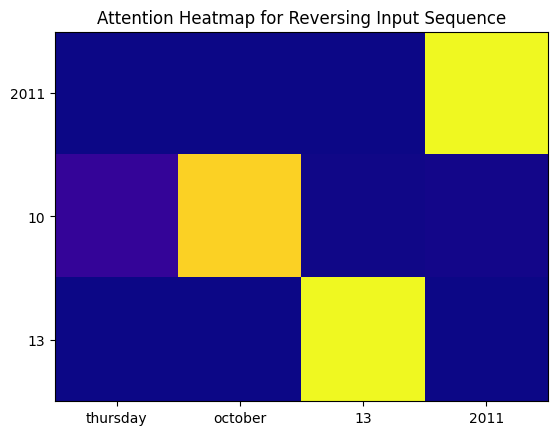

In [38]:
plt.imshow(attention_dict['Epoch 39'], cmap='plasma')
plt.title('Attention Heatmap for Reversing Input Sequence')
plt.xticks(range(len(hr_val[105])), labels=hr_val[105])
plt.yticks(range(len(mr_val[105])), labels=mr_val[105])
plt.show()

In [40]:
for key in attention_dict:
    plt.imshow(attention_dict[key], cmap='plasma')
    plt.title(key)
    plt.title('Attention Heatmap')
    plt.xticks(range(len(hr_val[105])), labels=hr_val[105])
    plt.yticks(range(len(mr_val[105])), labels=mr_val[105])
    plt.colorbar()
    
    file_name = f'{key}.png'
    plt.savefig(f'/kaggle/working/{file_name}')
    plt.close()

In [41]:
frames = list()

for key in attention_dict:
    img = Image.open(f'/kaggle/working/{key}.png')
    img = img.convert('RGB')
    
    frames.append(img)
    
frames[0].save('date_attention.gif', save_all=True, append_images=frames[1:], duration=150, loop=0)